<a href="https://colab.research.google.com/github/sayakpaul/MIRNet-TFLite/blob/main/MIRNet_TRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows the TensorRT model conversion and inference processes for the **MIRNet** model as proposed by [Learning Enriched Features for Real Image Restoration and Enhancement](https://arxiv.org/pdf/2003.06792v2.pdf). This model is capable of enhancing low-light images upto a great extent. 

<p align="center">
<img src="https://github.com/soumik12345/MIRNet/raw/master/assets/lol_results.gif"</img><br>
<small><a href="https://github.com/soumik12345/MIRNet/blob/master/assets/lol_results.gif">Source</a></small>
</p>

Model training code and pre-trained weights are provided by **Soumik** through [this repository](https://github.com/soumik12345/MIRNet/). [link text](https://)

## Initial setup

In [1]:
# Which GPU?
!nvidia-smi

Fri Dec 18 05:44:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/soumik12345/MIRNet
%cd MIRNet

Cloning into 'MIRNet'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 213 (delta 94), reused 148 (delta 40), pack-reused 0
Receiving objects: 100% (213/213), 28.12 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (94/94), done.
/content/MIRNet


In [3]:
!pip install -q wandb

     |████████████████████████████████| 1.8MB 22.9MB/s 
     |████████████████████████████████| 163kB 57.0MB/s 
     |████████████████████████████████| 133kB 63.9MB/s 
     |████████████████████████████████| 102kB 15.6MB/s 
     |████████████████████████████████| 102kB 15.1MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 


In [24]:
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
from mirnet.inference import Inferer
from mirnet.utils import download_dataset, plot_result
from tensorflow.python.compiler.tensorrt import trt_convert as trt

import tensorflow as tf
import numpy as np
import time
print(tf.__version__)

2.4.0


## Download dataset and pre-trained weights

In [5]:
download_dataset('LOL')

Downloading...
From: https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB
To: /content/MIRNet/LOLdataset.zip
347MB [00:04, 86.0MB/s]


Unpacking Dataset
Done!!!


In [6]:
inferer = Inferer()
inferer.download_weights('1sUlRD5MTRKKGxtqyYDpTv7T3jOW6aVAL')
inferer.build_model(
    num_rrg=3, num_mrb=2, channels=64,
    weights_path='low_light_weights_best.h5'
)

Downloading...
From: https://drive.google.com/uc?id=1sUlRD5MTRKKGxtqyYDpTv7T3jOW6aVAL
To: /content/MIRNet/low_light_weights_best.h5
148MB [00:01, 124MB/s] 


In [10]:
# Save model in SavedModel format
inferer.model.save('mirnet_saved_model')

INFO:tensorflow:Assets written to: mirnet_saved_model/assets


## TensorRT model conversion

In [11]:
# Specify the conversion parameters
params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode='FP16',
    is_dynamic_op=True)

# Convert the model
converter = trt.TrtGraphConverterV2(
      input_saved_model_dir='mirnet_saved_model',
      conversion_params=params)
converter.convert()

# Save the model
converter.save('mirnet_trt')

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: mirnet_trt/assets


You can follow [this blog post](https://sayak.dev/tf.keras/tensorrt/tensorflow/2020/07/01/accelerated-inference-trt.html) to review some of the parameters used in the above code snippet. 

## Utility functions

In [17]:
# Load up a few image for running inference and specify the image dimensions
LOW_LIGHT_IMGS = glob('./eval15/low/*')[:10]
IMG_WIDTH, IMG_HEIGHT = 600, 400

In [14]:
def preprocess_image(image_path):
    original_image = Image.open(image_path)
    preprocessed_image = original_image.resize(
        (
            IMG_WIDTH,
            IMG_HEIGHT
        ),
        Image.ANTIALIAS)
    preprocessed_image = tf.keras.preprocessing.image.img_to_array(preprocessed_image)
    preprocessed_image = preprocessed_image.astype('float32') / 255.0
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    
    return original_image, preprocessed_image

Some parts of the above two functions have been referred from [here](https://github.com/soumik12345/MIRNet/blob/master/mirnet/inference.py). 

## Running inference with the TensorRT-optimized model

In [15]:
# Load up the model
root = tf.saved_model.load('mirnet_trt')
concrete_func = root.signatures['serving_default']

In [26]:
# Warm-up the GPU
for _ in range(100):
    dummy_image = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32)
    _ = concrete_func(input_1=dummy_image)["add_171"]
print("GPU warmed up!")

GPU warmed up!


[INFO] predictions took 0.68 seconds


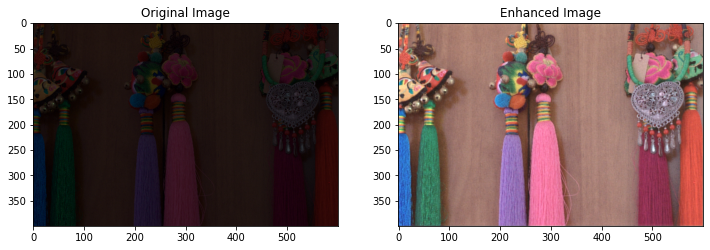

[INFO] predictions took 0.63 seconds


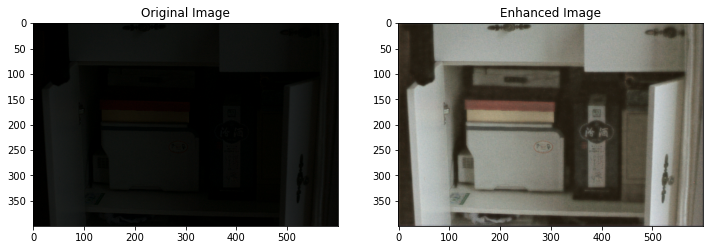

[INFO] predictions took 0.64 seconds


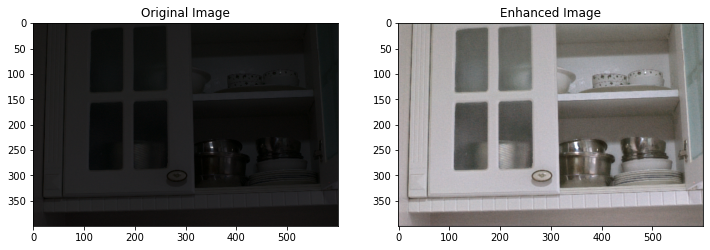

[INFO] predictions took 0.64 seconds


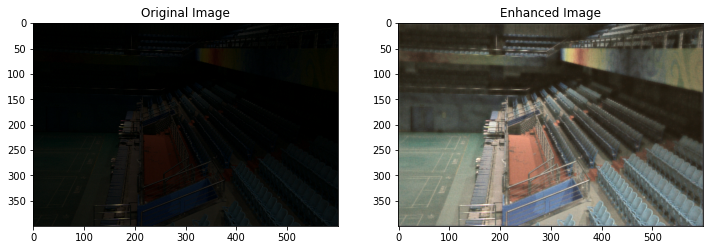

[INFO] predictions took 0.64 seconds


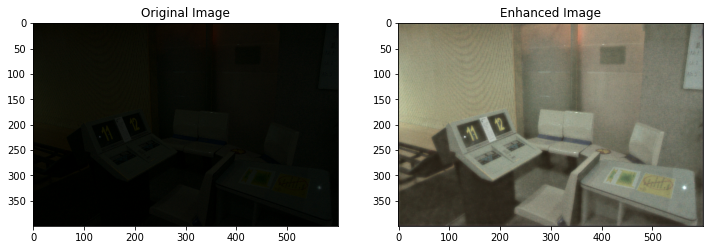

[INFO] predictions took 0.64 seconds


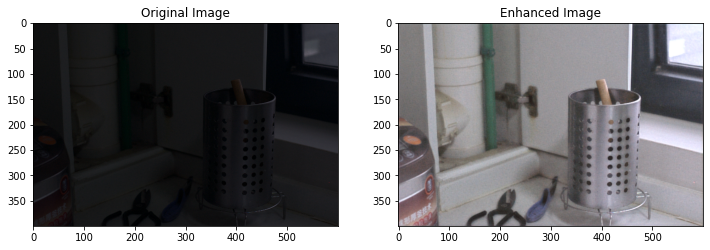

[INFO] predictions took 0.64 seconds


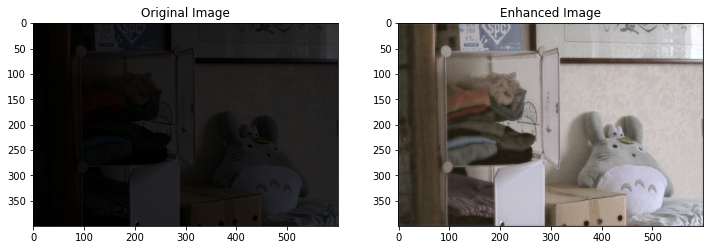

[INFO] predictions took 0.64 seconds


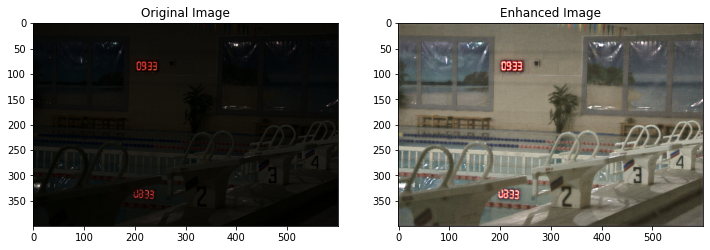

[INFO] predictions took 0.64 seconds


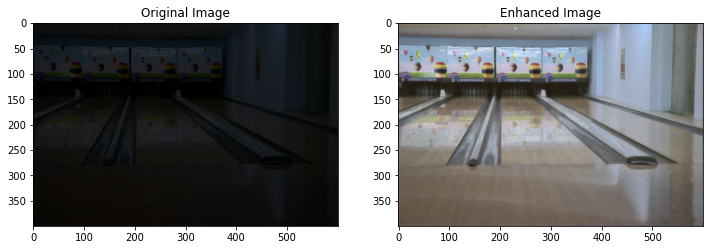

[INFO] predictions took 0.64 seconds


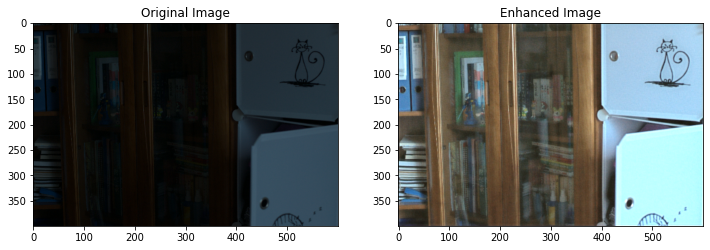

In [27]:
# Loop over the image paths
for image_path in LOW_LIGHT_IMGS:
    # preprocess the current image
    original_image, preprocessed_image = preprocess_image(image_path)

    # Run inference with the model and post-process the prediction
    start_time = time.time()
    output_image = concrete_func(input_1=preprocessed_image)["add_171"]
    total_time = time.time() - start_time
    print("[INFO] predictions took {:.2f} seconds".format(total_time))
    output_image = output_image.numpy().squeeze() * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.squeeze()
    output_image = Image.fromarray(np.uint8(output_image))

    # Plot the results
    fig = plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 2, 1).set_title("Original Image")
    plt.imshow(Image.fromarray(np.uint8(original_image)))
    fig.add_subplot(1, 2, 2).set_title("Enhanced Image")
    plt.imshow(output_image)
    plt.show()

Consider deploying this optimized model to an NVIDIA GPU-enabled device for optimal performance as opposed the models shown in [this notebook](https://colab.research.google.com/github/sayakpaul/MIRNet-TFLite/blob/main/MIRNet_TFLite_Fixed_Shape.ipynb).  

## Performing inference on a video

In [ ]:
# WIP